In [2]:
import foolbox as fb
import helperfiles.helpers as helpers
import helperfiles.experiment as experiment

In [ ]:
ds_train, ds_test, attack_images, attack_labels = helpers.load_data('imagenette')
model = helpers.initialize_base_model('ResNet8',ds_train,'',1, lr=1e-3)

Epoch 1/150
74/74 [==============================] - 11s 152ms/step - loss: 1.8468 - accuracy: 0.3594 - val_loss: 3.4615 - val_accuracy: 0.1391 - lr: 0.0010
Epoch 2/150
74/74 [==============================] - 7s 89ms/step - loss: 1.6029 - accuracy: 0.4516 - val_loss: 3.0609 - val_accuracy: 0.1462 - lr: 0.0010
Epoch 3/150
74/74 [==============================] - 7s 90ms/step - loss: 1.4500 - accuracy: 0.5085 - val_loss: 2.9691 - val_accuracy: 0.2005 - lr: 0.0010
Epoch 4/150
74/74 [==============================] - 7s 90ms/step - loss: 1.3318 - accuracy: 0.5555 - val_loss: 3.9434 - val_accuracy: 0.1946 - lr: 0.0010
Epoch 5/150
74/74 [==============================] - 7s 90ms/step - loss: 1.2214 - accuracy: 0.6010 - val_loss: 3.0641 - val_accuracy: 0.2787 - lr: 0.0010
Epoch 6/150
74/74 [==============================] - 7s 90ms/step - loss: 1.1252 - accuracy: 0.6301 - val_loss: 1.7128 - val_accuracy: 0.4599 - lr: 0.0010
Epoch 7/150
74/74 [==============================] - 7s 90ms/step - 

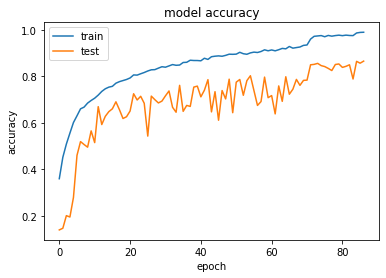

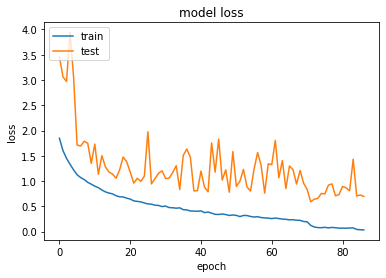

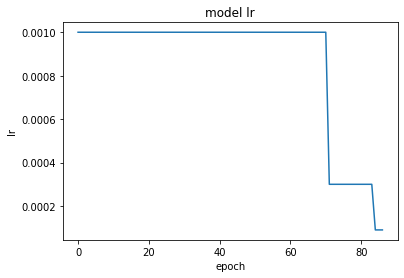

In [9]:
hist = helpers.train_model('ResNet8',ds_train, ds_test,model)
helpers.plot_hist(hist)

In [ ]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.L2CarliniWagnerAttack(
    binary_search_steps = 9,
    steps= 5000,
    stepsize = .01,
    confidence = 0,
    initial_const = 1000000,
    abort_early = True,
)

adversarials, _, batch_success = attack(
        fmodel,
        attack_images[:32],
        attack_labels[:32],
        epsilons=None
    )

l2_adv = adversarials
l2_pert = (attack_images[:32]-l2_adv)

In [ ]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
init_attack = fb.attacks.DatasetAttack()
BATCHSIZE = 64
batches = [
    (attack_images[:BATCHSIZE], attack_labels[:BATCHSIZE]), 
    (attack_images[BATCHSIZE:2*BATCHSIZE], attack_labels[BATCHSIZE:2*BATCHSIZE]),
    (attack_images[2*BATCHSIZE:3*BATCHSIZE], attack_labels[2*BATCHSIZE:3*BATCHSIZE]), 
    (attack_images[3*BATCHSIZE:4*BATCHSIZE], attack_labels[3*BATCHSIZE:4*BATCHSIZE])
]

init_attack = fb.attacks.DatasetAttack()

init_attack.feed(fmodel, batches[0][0])   # feed 1st batch of inputs
init_attack.feed(fmodel, batches[1][0])   # feed 2nd batch of inputs
init_attack.feed(fmodel, batches[2][0])   # feed 1st batch of inputs
init_attack.feed(fmodel, batches[3][0])   # feed 2nd batch of inputs
attack = fb.attacks.L0BrendelBethgeAttack(binary_search_steps=30, steps=500,lr_num_decay=30, lr=1e7, init_attack=init_attack)

adversarials, _, batch_success = attack(
    fmodel,
    attack_images[:32],
    criterion=fb.criteria.Misclassification(attack_labels[:32]),
    epsilons=[None]
)
l0_adv = adversarials[0]

l0_pert = (attack_images[:32]-l0_adv)

In [38]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.LinfProjectedGradientDescentAttack()
res = [[],[],[],[],[],[]]
strengths = [0.125,0.25,0.5,1,2,4]


adversarials, _, success = attack(
    fmodel,
    attack_images[:32],
    attack_labels[:32],
    epsilons=8/255
)
l_inf_adv = adversarials

l_inf_pert = (attack_images[:32]-l_inf_adv)

In [39]:
advs = {
    'l0':{
        'original':attack_images[0],
        'adversarial':l0_adv,
        'perturbation':l0_pert,
        'adversarial_class':5,
    },
    'l2':{
        'original':attack_images[0],
        'adversarial':l2_adv,
        'perturbation':l2_pert,
        'adversarial_class':8
    },
    'linf':{
        'original':attack_images[0],
        'adversarial':l_inf_adv,
        'perturbation':l_inf_pert,
        'adversarial_class':8
    },
}

import pickle
filename = 'advs'
outfile = open(filename,'wb')
pickle.dump(advs,outfile)
outfile.close()

In [120]:
labels = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

In [ ]:
import matplotlib.pyplot as plt

chain saw


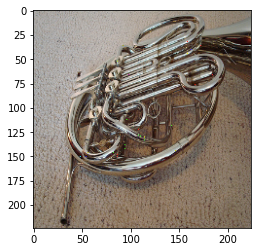

In [136]:
plt.imshow(l0_adv[17:18][0])
plt.imsave('l0_adv.png', (l0_adv[17:18][0]).numpy())
print(labels[np.argmax(model(l0_adv[17:18]))])

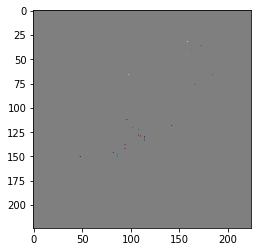

In [140]:
plt.imshow((l0_pert[17:18][0]+.5))
plt.imsave('l0_pert.png', np.clip((l0_pert[17:18][0]+.5).numpy(), 0,1))

chain saw


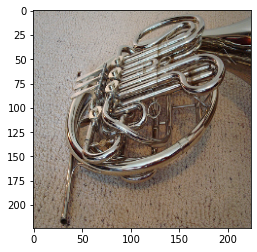

In [141]:
plt.imshow(l2_adv[17:18][0])
plt.imsave('l2_adv.png', np.clip((l2_adv[17:18][0]).numpy(), 0,1))
print(labels[np.argmax(model(l2_adv[17:18]))])

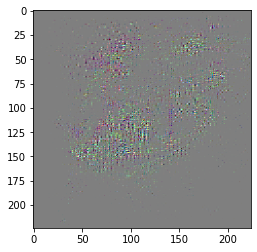

In [142]:
plt.imshow((l2_pert[17:18][0]*50+.5))
plt.imsave('l2_pert_50x.png', np.clip((l2_pert[17:18][0]*50+.5).numpy(), 0,1))

chain saw


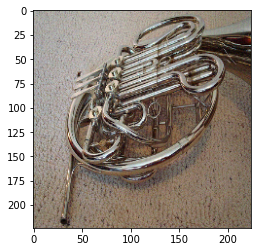

In [144]:
plt.imshow(l_inf_adv[17:18][0])
plt.imsave('l_inf_adv.png', np.clip((l_inf_adv[17:18][0]).numpy(), 0,1))
print(labels[np.argmax(model(l_inf_adv[17:18]))])

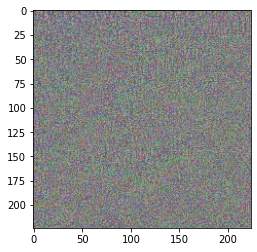

In [145]:
plt.imshow((l_inf_pert[17:18][0]*5+.5))
plt.imsave('l_inf_pert_5x.png', np.clip((l_inf_pert[17:18][0]*5+.5).numpy(), 0,1))

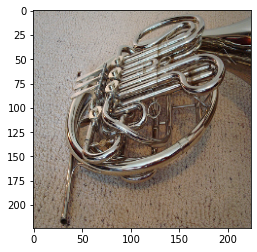

In [150]:
plt.imshow((attack_images[17:18][0]))
plt.imsave('original.png', np.clip((attack_images[17:18][0]).numpy(), 0,1))